In [1]:
import sys
import pathlib
cwd = pathlib.Path().cwd()
sys.path.append(cwd.parent.as_posix())
data_folder = cwd.parent.joinpath('data')

import logging
import datetime as dt
import pandas as pd

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from functools import partial

from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin

from dags.jobs.transformers import Merger, TimeDifference, Clusterer, AsDummies, PurchaseRatio, ColumnsCorrector, BasicFiller
from sklearn.ensemble import RandomForestClassifier
from auxiliary import cv_fit, whole_fit

import matplotlib.pyplot as plt

FORMAT = '%(asctime)s > %(message)s'
logging.basicConfig(filename='fit.log', level=logging.INFO, format=FORMAT)

## load

In [2]:
n_folds = 5
bound_date = '2018-11-19'

In [3]:
# read train data
train_data = pd.read_csv(data_folder.joinpath('data_train.csv')).drop('Unnamed: 0', axis=1)
# extract required train data
train_data = train_data[train_data['buy_time'] >= dt.datetime.fromisoformat(bound_date).timestamp()]
# data/target split
data = train_data.drop('target', axis=1)
target = train_data['target']

# read compressed features
features = pd.read_csv(data_folder.joinpath('compressed_features.csv'))

# calc class weights
class_weights = dict(enumerate(compute_class_weight('balanced', classes=[0, 1], y=train_data['target'])))
# prepare folds for CV fit
folds = KFold(n_splits=n_folds, shuffle=True, random_state=29)
# prepare scoring function
f1_macro = partial(f1_score, average='macro')

## workspace

In [6]:
# prepare dataset for feature engineering
pipeline = make_pipeline(
    Merger(features, method='backward', fillna='nearest'),
    TimeDifference('feats_time', 'train_time'),
    Clusterer(['0', '1', '2'], n_clusters=8, random_state=13),
    
)
ft = pipeline.fit_transform(data, target)
ft['target'] = target.values
ft.head()

,id,vas_id,train_time,feats_time,0,1,2,time_diff,cluster,target
6,2611143.0,2.0,1.544994e+09,1.533503e+09,6.779413e+08,-2.634963e+08,-8.669099e+07,133,1,0.0
7,3577737.0,5.0,1.545599e+09,1.531084e+09,2.525749e+08,1.176470e+09,-1.521874e+08,168,3,0.0
9,1232876.0,2.0,1.544994e+09,1.532293e+09,2.518684e+08,1.178862e+09,-1.522962e+08,147,3,0.0
22,1054880.0,1.0,1.544994e+09,1.535922e+09,1.936687e+08,1.252885e+09,1.229307e+09,105,0,0.0
24,1759351.0,2.0,1.546204e+09,1.544389e+09,6.779413e+08,-2.634963e+08,-8.669099e+07,21,1,0.0


## data overview

In [14]:
# pipeline = make_pipeline(
#     Merger(features, method='backward', fillna='nearest'),
#     TimeDifference('feats_time', 'train_time'),
    
#     Clusterer(['0', '1', '2'], n_clusters=8, random_state=13),
#     AsDummies(['cluster']),
#     PurchaseRatio(by=['cluster']),

#     ColumnsCorrector('drop', ['id', 'train_time', 'feats_time', 'cluster']),
#     BasicFiller(strategy='mean', apply_on_fly=True),
# )
# pipeline.fit_transform(data, target)

## manual fit

In [4]:
# final pipeline
pipeline = make_pipeline(
    Merger(features, method='backward', fillna='nearest'),
    TimeDifference('feats_time', 'train_time'),
    Clusterer(['0', '1', '2'], n_clusters=8, random_state=13),
    # AsDummies(['cluster']),
    PurchaseRatio(by=['cluster']),
    ColumnsCorrector('drop', ['id', 'train_time', 'feats_time']),
    BasicFiller(strategy='mean', apply_on_fly=True),
    
    RandomForestClassifier(random_state=17, n_jobs=-1, class_weight=class_weights,
                           n_estimators=75,
                           # max_depth=6,
                           min_samples_leaf=7,
                           )
)

avg, _, _ = cv_fit(pipeline, data, target, cv=folds, scorer=f1_macro, logger=logging, prefix='[CVFIT]')
score, model = whole_fit(pipeline, data, target, scorer=f1_macro, logger=logging, prefix='[WHOLE]')

[CVFIT] Pipeline: 0.7393289956954152
[WHOLE] Pipeline: 0.7538075980383957


In [ ]:
# basic metrics
# [CVFIT] Pipeline: 0.720716
# [WHOLE] Pipeline: 0.826181

In [11]:
# check for random states stability
N_RANGE = 3

rs_temp = pipeline[-1].get_params()['random_state']
pipeline[-1].set_params(random_state=None)
metrics = []
for n in range(N_RANGE):
    pipeline.fit(data, target)
    score, _, _ = cv_fit(pipeline, data, target, cv=folds, scorer=f1_macro, logger=logging, prefix='[RS] [CVFIT]')
    # score = f1_score(target, pipeline.predict(data), average='macro')
    # print(f'step {n + 1}/{N_RANGE}: {score}')
    metrics.append(score)
pipeline[-1].set_params(random_state=rs_temp)
print(f'Avg. RS metric: {sum(metrics) / len(metrics)}')

[RS] [CVFIT] Pipeline: 0.7200951125090721
step #1/3: 0.7200951125090721
[RS] [CVFIT] Pipeline: 0.7197676499138935
step #2/3: 0.7197676499138935
[RS] [CVFIT] Pipeline: 0.7204335737757693
step #3/3: 0.7204335737757693
Avg. RS metric: 0.7200987787329116


## feature importances

In [24]:
# score, model = whole_fit(pipeline, data, target, scorer=f1_macro, logger=logging, prefix='[WHOLE]')

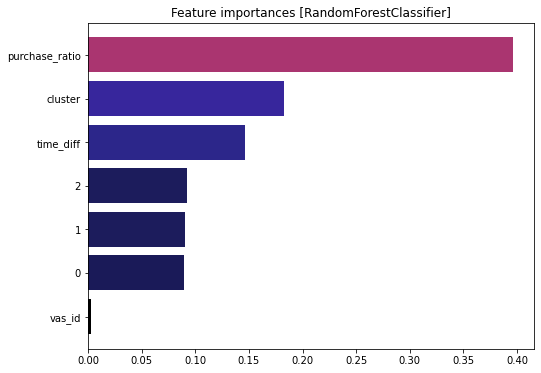

In [27]:
sorted_importances = sorted(model[-1].feature_importances_)

fig = plt.figure(figsize=(8, 6))
plt.title(f'Feature importances [{model[-1].__class__.__name__}]')
cmap = plt.get_cmap('CMRmap')(sorted_importances)
plt.barh(model[-1].feature_names_in_, sorted_importances, color=cmap);

## conclusion

Признак кластера совершенно бесполезен как dummies, но имеет вес в нераздленном виде. Производный признак `purchase_ratio` демонстрирует высокую значимость, хотя эмпирически на метрике не отражается. Также, при его использовании значимость `vas_id` падает практически до нуля, но удаление этого признака на первый взгляд также не отражается на метрике.

In [ ]:
#